# 암트랙 열차 승객수

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools

(1300.0, 2300.0)

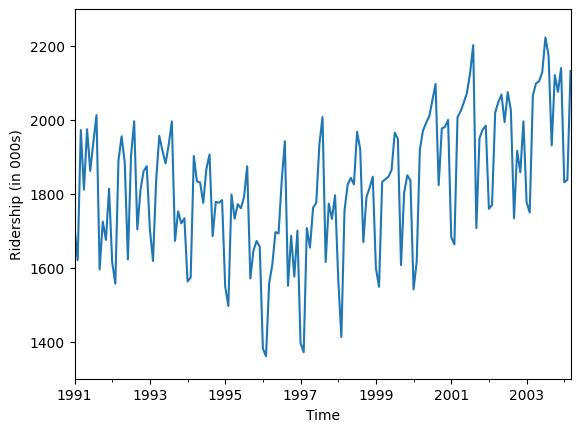

In [2]:
Amtrak_df = pd.read_csv('Amtrak.csv')

# convert the date information to a datetime object
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format = '%d/%m/%Y')

# convert dataframe column to series(name is used to label the data)
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index = Amtrak_df.Date,
                        name = 'Ridership')

# define the time series frequency
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index,
                                     freq = ridership_ts.index.inferred_freq)

# plot the series
ax = ridership_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(1300,2300)


# 시계열 자세히보기(1) 확대

(50000.0, 150000.0)

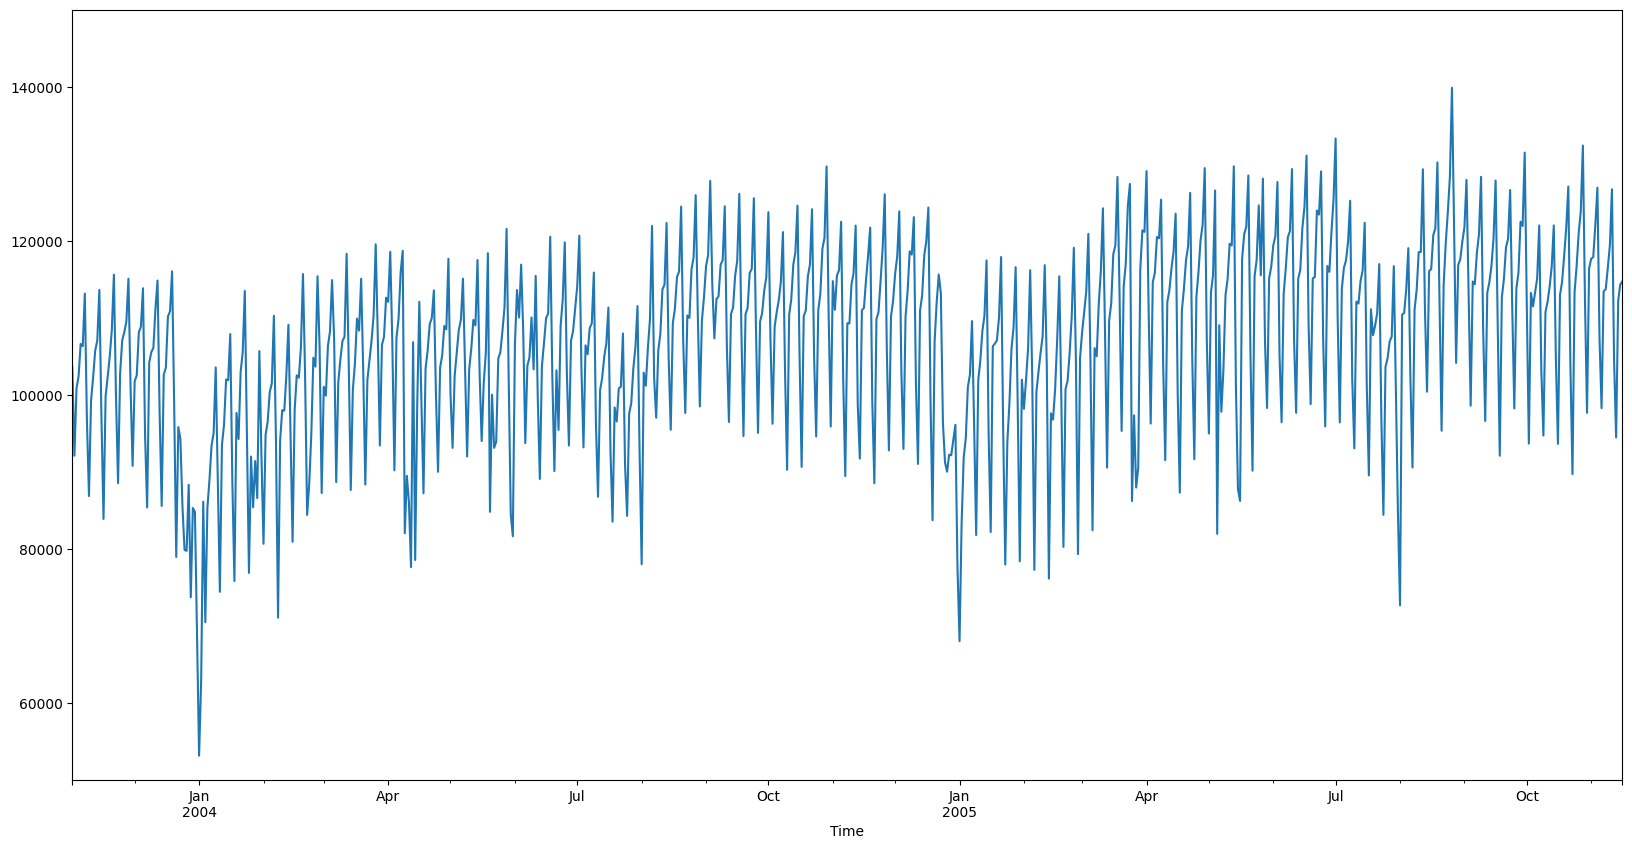

In [18]:
Baregg_df = pd.read_csv('BareggTunnel.csv')

# convert the date information to a datetime object
Baregg_df['Day'] = pd.to_datetime(Baregg_df['Day'], format = '%d %b %Y')

# convert dataframe column to series(name is used to label the data)
Baregg_ts = pd.Series(Baregg_df['Number of vehicles'].values, index = Baregg_df['Day'],
                        name = '# of Vehicles')

# define the time series frequency
Baregg_ts.index = pd.DatetimeIndex(Baregg_ts.index,
                                     freq = Baregg_ts.index.inferred_freq)

# plot the series
plt.figure(figsize=(20,10))
ax = Baregg_ts.plot()
ax.set_xlabel('Time')
ax.set_ylim(50000,150000)

<Axes: xlabel='Day'>

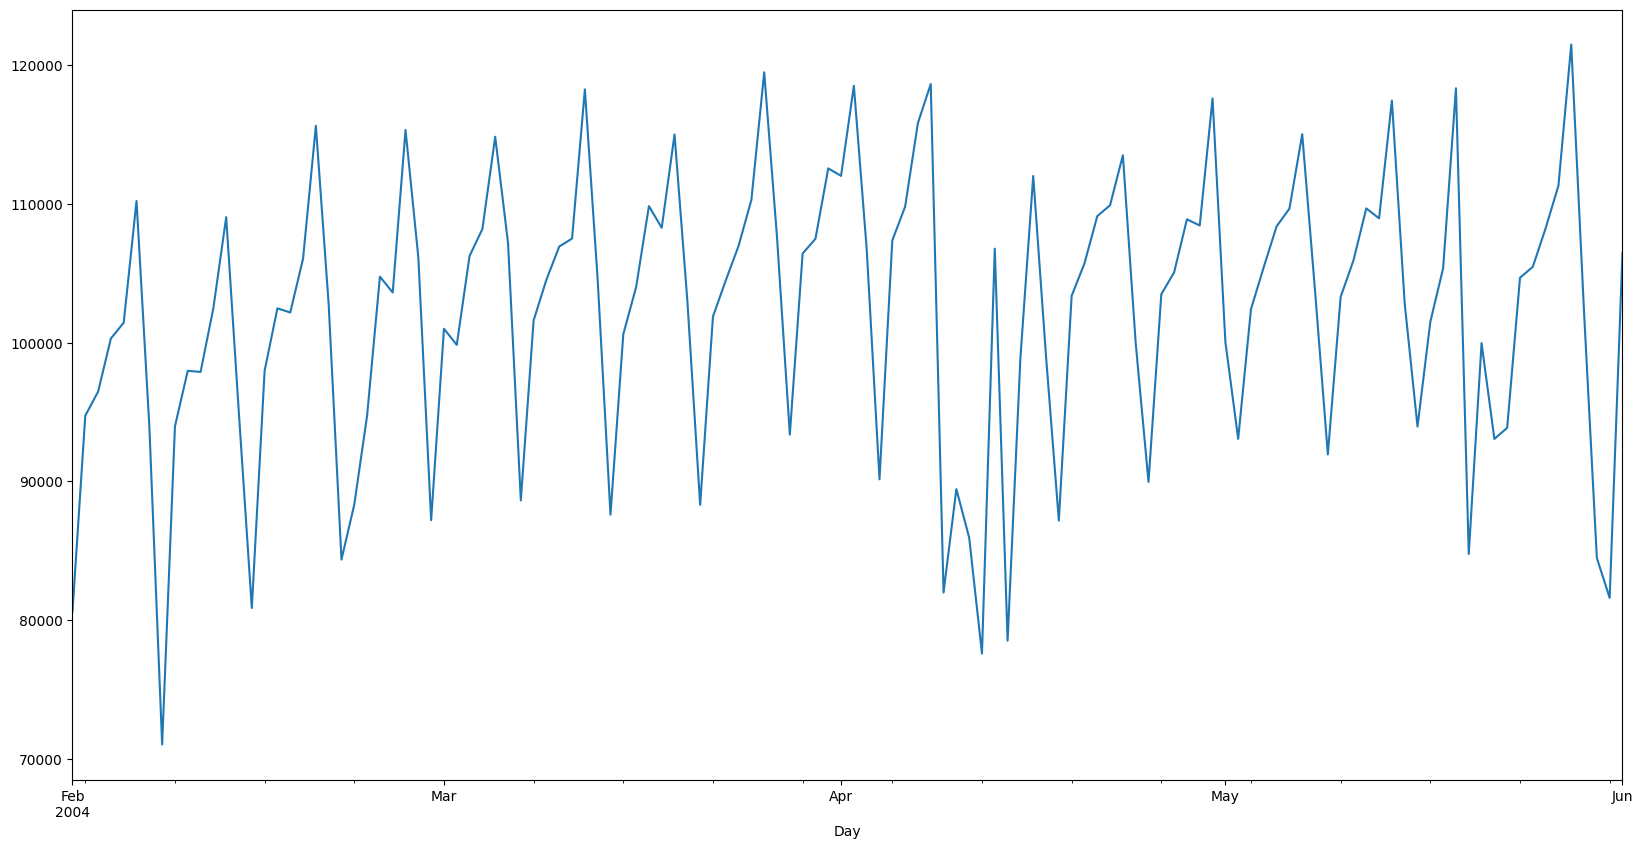

In [22]:
plt.figure(figsize=(20,10))
Baregg_ts.loc['2004-02-01':'2004-06-01'].plot()

# 시계열 자세히보기(2) log scale로 변화

<Axes: xlabel='Day'>

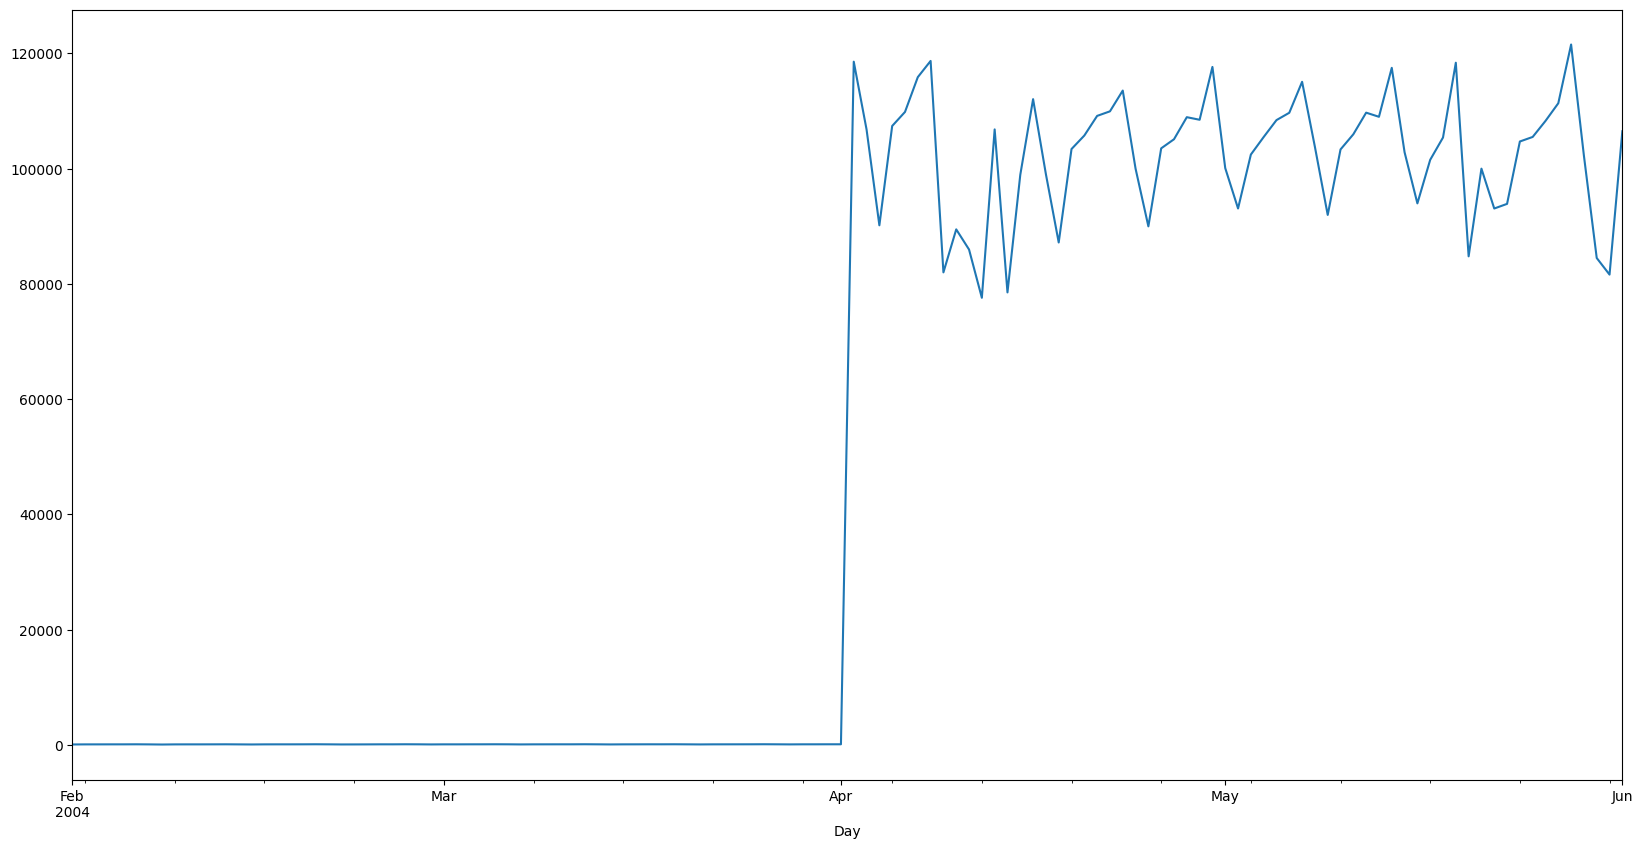

In [33]:
plt.figure(figsize=(20,10))
Baregg_ts_copy = Baregg_ts.copy()
Baregg_ts_copy.loc['2004-02-01':'2004-04-01'] = Baregg_ts_copy.loc['2004-02-01':'2004-04-01']/1000
Baregg_ts_copy.loc['2004-02-01':'2004-06-01'].plot()

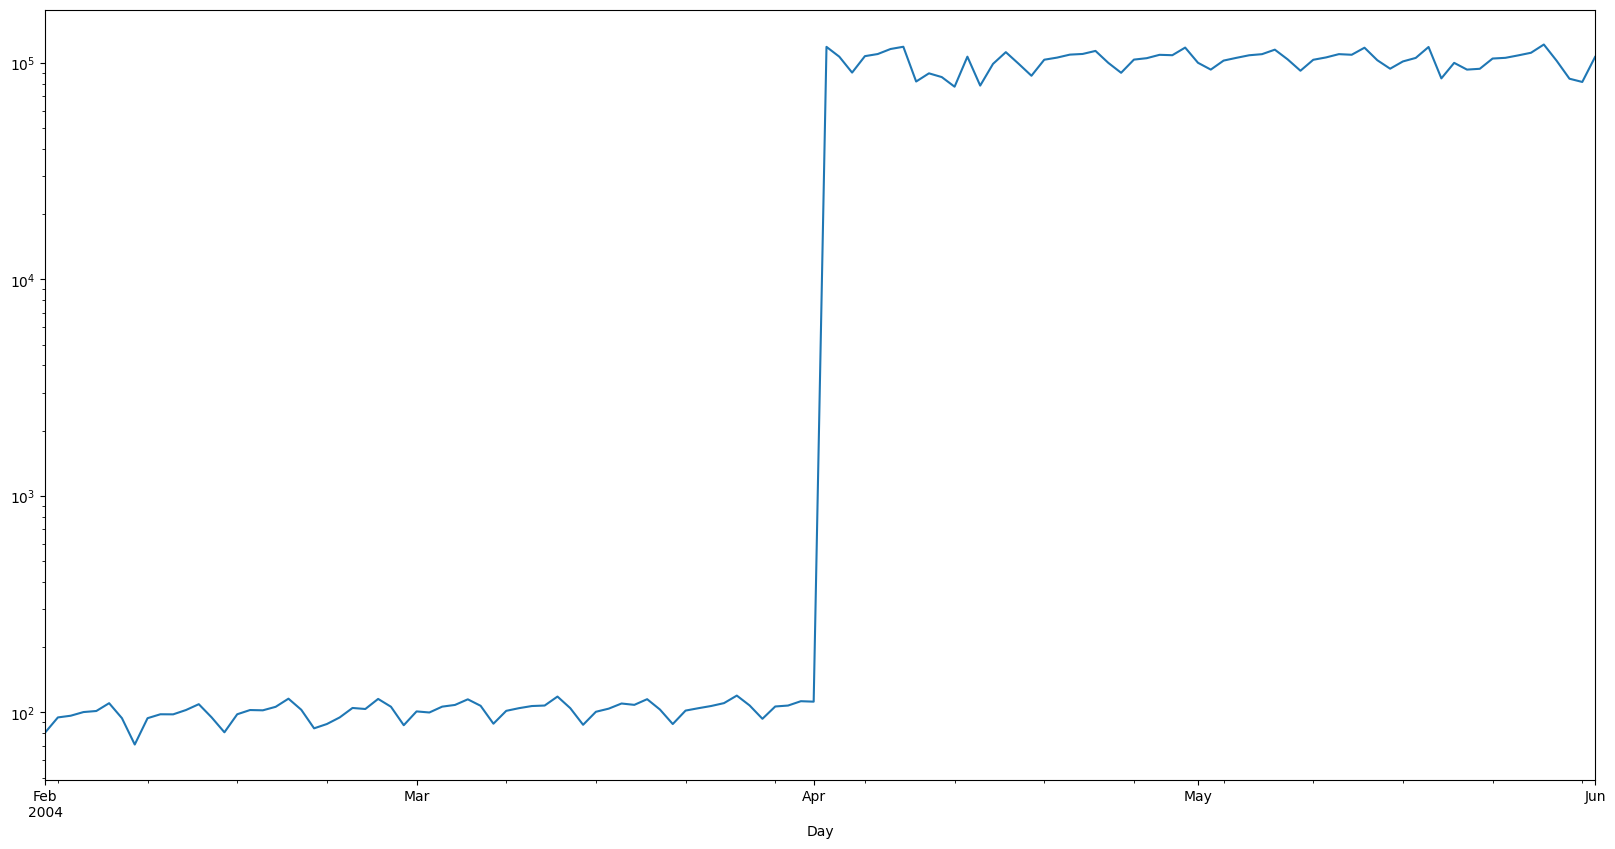

In [34]:
plt.figure(figsize=(20,10))
ax = Baregg_ts_copy.loc['2004-02-01':'2004-06-01'].plot()
ax.set_yscale('log')

# 시계열 자세히보기(3) 추세선 추가
* 여기서는 데이터가 2차함수의 추세를 갖는다고 가정하고 추세선을 Fitting 시켜보겠다.
* 위에서 사용했던 Amtrak_df를 이용한다.

In [36]:
# create short time series from 1997 to 1999 using a slice
ridership_ts_3yrs = ridership_ts['1997':'1999']

# creat a data frame with additional predictors from time series
# the following command adds a constant term, a trend term and a quadratic trend term
# 단순히 1,2,3,4가 통과되면서 상수함수 1차함수 2차함수를 구해준다.
ridership_df = tsatools.add_trend(ridership_ts,trend = 'ctt')
ridership_df

,Ridership,const,trend,trend_squared
Date,,,,
1991-01-01,1708.917,1.0,1.0,1.0
1991-02-01,1620.586,1.0,2.0,4.0
1991-03-01,1972.715,1.0,3.0,9.0
1991-04-01,1811.665,1.0,4.0,16.0
1991-05-01,1974.964,1.0,5.0,25.0
...,...,...,...,...
2003-11-01,2076.054,1.0,155.0,24025.0
2003-12-01,2140.677,1.0,156.0,24336.0
2004-01-01,1831.508,1.0,157.0,24649.0


In [37]:
# fit a linear regression model to the time series
ridership_lm = sm.ols(formula = 'Ridership ~ trend + trend_squared', data = ridership_df).fit()
ridership_lm

위의 `'Ridership ~ trend + trend_squared'` formula가 의미하는 바는 다음과 같다.<br>
&rightarrow; $Ridership = \alpha\times trend + \beta \times trendsquared$

In [39]:
ridership_lm.params

Intercept        1854.264616
trend              -4.449425
trend_squared       0.038074
dtype: float64

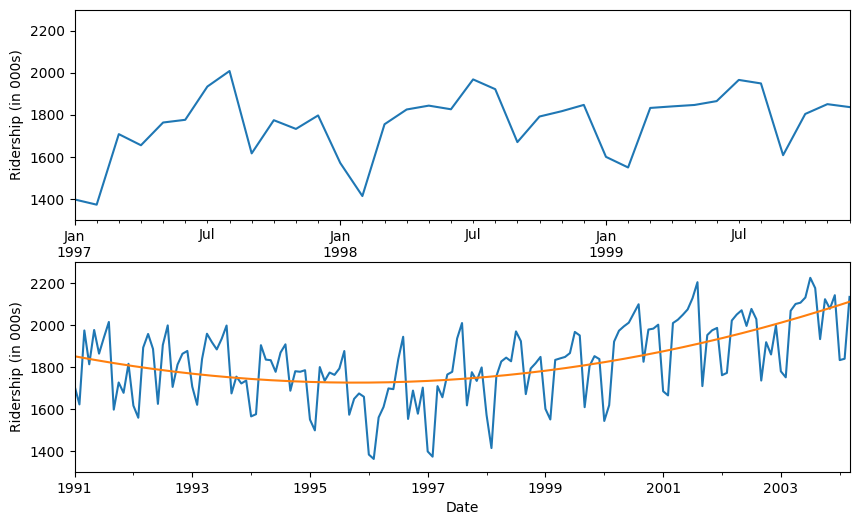

In [38]:
# shorter and longer time series
fig, axes = plt.subplots(nrows=2, ncols = 1, figsize = (10,6))
ridership_ts_3yrs.plot(ax = axes[0])
ridership_ts.plot(ax = axes[1])
for ax in axes:
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')
    ax.set_ylim(1300,2300)
ridership_lm.predict(ridership_df).plot(ax=axes[1])
plt.show()

# 암트랙 승객 수 데이터의 Naive Forecasts와 Seasonal Naive Forecasts의 비교

In [47]:
ridership_ts

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
                ...   
2003-11-01    2076.054
2003-12-01    2140.677
2004-01-01    1831.508
2004-02-01    1838.006
2004-03-01    2132.446
Freq: MS, Name: Ridership, Length: 159, dtype: float64

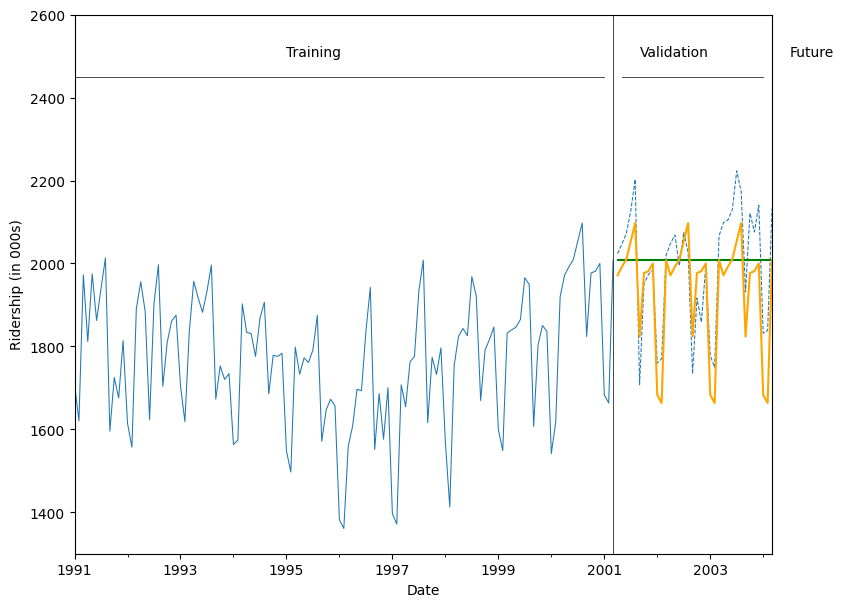

In [48]:
nValid = 36
nTrain = len(ridership_ts) - nValid

# partition the data
train_ts = ridership_ts[:nTrain]
valid_ts = ridership_ts[nTrain:]

# generate the naive and seasonal naive forecast
naive_pred = pd.Series(train_ts[-1],index = valid_ts.index)
last_season = train_ts[-12:]
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values,
                         index = valid_ts.index)

# plot forecasts and actual in the training and validation sets
ax = train_ts.plot(color = 'C0', linewidth = 0.75, figsize = (9,7))
valid_ts.plot(ax=ax, color = 'C0', linestyle = 'dashed', linewidth = 0.75)
ax.set_xlim('1990','2005')
ax.set_ylim(1300,2600)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')

naive_pred.plot(ax = ax, color = 'green')
seasonal_pred.plot(ax = ax, color = 'orange')

# determine coordinates for drawing the arrows and lines
one_month = pd.Timedelta('31 days')

# x좌표지정
xtrain = (min(train_ts.index), max(train_ts.index)-one_month)
xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index)-one_month)
xfuture = (max(valid_ts.index) + one_month, ' 2006')

# 수직선 x좌표
# train-validation
xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
# validation-future
xvf = xvalid[1] + 0.5 * (xfuture[0] - xvalid[1])

ax.add_line(plt.Line2D(xtrain, (2450,2450), c = 'black', linewidth = 0.5))
ax.add_line(plt.Line2D(xvalid, (2450,2450), c = 'black', linewidth = 0.5))
ax.add_line(plt.Line2D(xfutrue, (2450,2450), c = 'black', linewidth = 0.5))
ax.text('1995',2500,'Training')
ax.text('2001-9',2500,'Validation')
ax.text('2004-7',2500,'Future')
ax.axvline(x = xtv, ymin = 0, ymax=1, color = 'black', linewidth = 0.5)
ax.axvline(x = xvf, ymin = 0, ymax=1, color = 'black', linewidth = 0.5)

plt.show()

# 암트랙 승객수 데이터의 단순 예측에 대한 정확도
* 계절 단순 예측이 더 좋은 예측 성능을 보이는 것을 볼 수 있다.

In [49]:
from dmba import regressionSummary

no display found. Using non-interactive Agg backend


In [50]:
regressionSummary(valid_ts,naive_pred)


Regression statistics

                      Mean Error (ME) : -14.7177
       Root Mean Squared Error (RMSE) : 142.7551
            Mean Absolute Error (MAE) : 115.9234
          Mean Percentage Error (MPE) : -1.2750
Mean Absolute Percentage Error (MAPE) : 6.0214


In [51]:
regressionSummary(valid_ts,seasonal_pred)


Regression statistics

                      Mean Error (ME) : 54.7296
       Root Mean Squared Error (RMSE) : 95.6243
            Mean Absolute Error (MAE) : 84.0941
          Mean Percentage Error (MPE) : 2.6528
Mean Absolute Percentage Error (MAPE) : 4.2477
